# Domino is a python package designed to simplify the analysis of weather composites. It can be used to analyse  either individual case studies, or perform a bulk analysis of a whole class of events. In this notebook we demonstrate the basic functionality and syntax of the package's main object, the *LaggedAnalyser*.

## *LaggedAnalyser* computes lagged composites of scalar indices and spatial fields, with respect to a categorical time series of events. Both continuous and categorical variables are supported.

In [2]:
import sys
sys.path.append('./..')
from composites import LaggedAnalyser

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from dask.distributed import Client
from plotting import contourf_grid,overlay_contour,cat_1d_plot,cat_2d_plot

In [2]:
dask_client=Client()
chunks={'time':-1,'lat':20,'lon':20}


/home/ws/ox5324/miniconda3/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34949 instead
  warnings.warn(


### *LaggedAnalyser* takes two different kinds of data as inputs. The first is a categorical time series, specifying classes of events, which is stored as a DataArray in *LaggedAnalyser.event*.

### The second are time series of arbitrary dimensional data, either categorical or continuous, that are stored in *LaggedAnalyser.variables* as a Dataset. These will be composited, conditioned on the value of *LaggedAnalyser.event*.

### We will introduce 3 short examples:

# Example 1: Precursors to extreme events

### We look at the large scale flow preceding extreme rainfall in Italy in SON. We loaf a series of extreme rainfall data, which is 1 when SON 5-day average precip over North Italy exceeds the climatological 90th percentile, and is 0 otherwise:

##### N.B While here we only have a binary time series, events with more than two categorical states are also supported

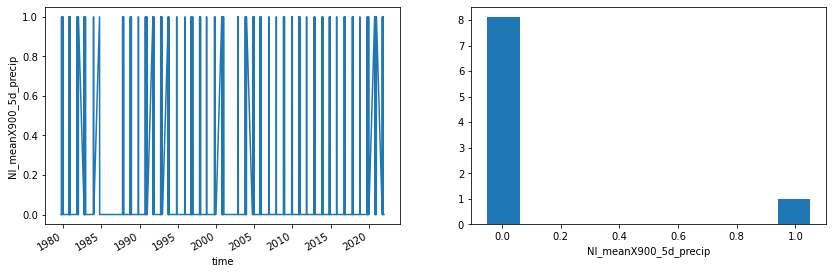

In [3]:
extreme_rainfall=xr.open_dataarray('../example_data/NorthItalian_SON_90Percentile_5dPrecip.nc')
fig,ax=plt.subplots(1,2)
fig.set_figwidth(14)
extreme_rainfall.plot(ax=ax[0]);
extreme_rainfall.plot.hist(ax=ax[1],density=1,bins=np.linspace(-0.05,1.05,11));

### We now load some field variables that we think may be useful predictors of the rainfall series: 500 hPa geopotential height and integrated vapour transport
##### PrecursorAnalyser works well with dask, allowing data to be lazy loaded, and processed in parallel when needed

In [4]:
Z500_field=xr.open_dataarray('../example_data/Z500.nc',chunks=chunks)
IVT_field=xr.open_dataarray('../example_data/IVT.nc',chunks=chunks)

### We also include a categorical regime lifecycle index, using the 7 regime framework of Grams 2017:

In [5]:
regime_index=xr.open_dataarray('../example_data/Grams_regime_lifecycles.nc')

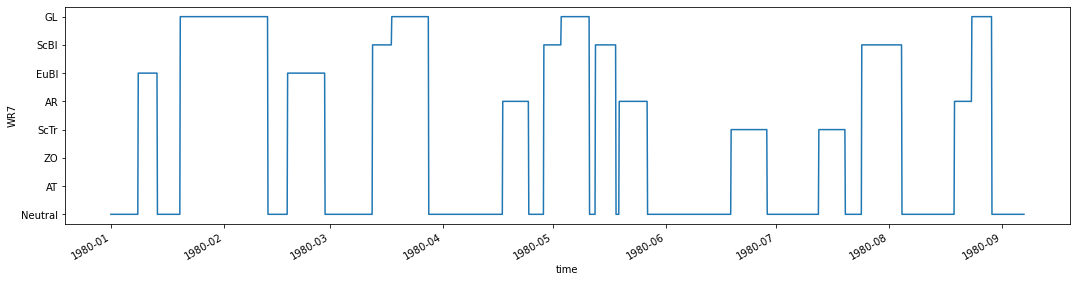

In [6]:
regime_index[:2000].plot()
plt.gca().set_yticks(np.arange(8))
plt.gca().set_yticklabels(regime_index.attrs['regime_labels']);
plt.gcf().set_figwidth(18)

### Now we have all the data we need we initalise a LaggedAnalyser object, and pass in our extreme rainfall time series as the 'event', and our Z500 field as one of our 'variables':

In [7]:
analyser=LaggedAnalyser(event=extreme_rainfall,variables=Z500_field,name='Z500')

## We can add additional variables after initialisation:

In [8]:
analyser.add_variable({'IVT':IVT_field})
analyser.add_variable(regime_index,name='WR7',is_categorical=True,join_type='inner')

### Within the LaggedAnalyser, the event is stored as an xarray DataArray and the variables are stored as an xarray Dataset.
### The time dimensions are of different sizes, but the event and the variables will be aligned when composites are computed.
##### N.B. If composites are to be computed as an anomaly, then the anomaly is computed with respect to the intersection of the event DataArray and the variables Dataset. This ensures an anomaly composite of an event series with only 1 value will be zero everywhere.

In [9]:
## Here, we choose to load all our variables as we have enough memory to do so,
## and it improves the performance of the computation of composites and significance tests.
## However we could precede lazily if we wanted.
analyser.variables.load();
print(analyser)

A Precursorself object
event:

<xarray.DataArray 'NI_meanX900_5d_precip' (time: 3954)>

variables:

<xarray.Dataset> Dimensions:  (time: 6273, lon: 71, lat: 28)
Data variables:
    Z500     (time, lat, lon) float32 135.1 110.4 75.23 0.8164 ... nan nan nan
    IVT      (time, lat, lon) float64 -83.33 -48.78 -14.39 12.54 ... nan nan nan
    WR7      (time) float64 6.0 6.0 6.0 6.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0


In [10]:
print(analyser.event)

<xarray.DataArray 'NI_meanX900_5d_precip' (time: 3954)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * time     (time) datetime64[ns] 1979-10-01 1979-10-02 ... 2021-12-29


In [11]:
print(analyser.variables)

<xarray.Dataset>
Dimensions:  (time: 6273, lon: 71, lat: 28)
Coordinates:
  * time     (time) datetime64[ns] 1980-08-01 1980-08-02 ... 2020-12-31
  * lon      (lon) float32 -80.0 -78.0 -76.0 -74.0 -72.0 ... 54.0 56.0 58.0 60.0
  * lat      (lat) float32 30.0 32.0 34.0 36.0 38.0 ... 76.0 78.0 80.0 82.0 84.0
Data variables:
    Z500     (time, lat, lon) float32 135.1 110.4 75.23 0.8164 ... nan nan nan
    IVT      (time, lat, lon) float64 -83.33 -48.78 -14.39 12.54 ... nan nan nan
    WR7      (time) float64 6.0 6.0 6.0 6.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0


# We now lag the variable dataset and make composites. Positive lags correspond to the variables preceding the event, and negative lags to the variables following the event. Here, because we are looking at precursors, we choose positive lags. 

##### To be extra safe, we set mode='past' which will raise an error if we somehow accidentally input lags with the wrong sign.
##### N.B. Lagged variables are only shallow copies: we don't use more memory by defining lags

In [12]:
analyser.lag_variables(np.arange(2,15,2),offset_unit='days',mode='past')

In [13]:
#composites is also stored in analyser.composites after computation
#N.B. When using as_anomaly=True, the anomaly for each variable is computed with respect to the time period defined by the event index.
composites=analyser.compute_composites(as_anomaly=True)

### Let's look at our Z500 composite. As well as the lat and lon coords present in the Z500 time series, it also has a lag coord and an index_val. The 2-D field composites.Z500[nlag,val] contains the average Z500 field 'nlag' days before the event index has a value 'val'. 
##### In this case, we are most interested in index_val==1, as this is when extreme precip is occurring. 

In [14]:
composites.Z500

<xarray.DataArray 'Z500' (lag: 8, index_val: 2, lat: 28, lon: 71)>
array([[[[ 6.29025602e+00,  5.78465223e+00,  5.02180195e+00, ...,
           1.24378853e+01,  1.00545988e+01,  7.85574007e+00],
         [ 6.13286209e+00,  5.58359814e+00,  5.27785873e+00, ...,
           1.25751591e+01,  1.01798811e+01,  8.06279373e+00],
         [ 5.33774281e+00,  4.84815311e+00,  4.95620251e+00, ...,
           1.18270359e+01,  9.98489189e+00,  8.80919456e+00],
         ...,
         [-1.48566322e+01, -1.43747005e+01, -1.38698101e+01, ...,
          -1.25438683e-02,  1.58977675e+00,  3.18330908e+00],
         [-1.30206900e+01, -1.29381504e+01, -1.28432684e+01, ...,
           2.99602413e+00,  4.36265373e+00,  5.81928062e+00],
         [-8.82841969e+00, -8.97351551e+00, -9.10112381e+00, ...,
           6.06777620e+00,  7.04176426e+00,  8.04231262e+00]],

        [[-4.70382957e+01, -4.32574196e+01, -3.75528603e+01, ...,
          -9.30100784e+01, -7.51879501e+01, -5.87449532e+01],
         [-4.58613052e+01, -4.17538376e+01, -3.94676285e+01, ...,
          -9.40366135e+01, -7.61248093e+01, -6.02932968e+01],
         [-3.99154243e+01, -3.62543449e+01, -3.70622406e+01, ...,
          -8.84421844e+01, -7.46666870e+01, -6.58748627e+01],
...
          -5.92371273e+00, -5.77274609e+00, -5.57378197e+00],
         [-1.34621868e+01, -1.34489746e+01, -1.34289513e+01, ...,
          -8.87149620e+00, -8.83216000e+00, -8.76991844e+00],
         [-1.33384991e+01, -1.30825462e+01, -1.28521080e+01, ...,
          -9.72862244e+00, -9.79225826e+00, -9.86547184e+00]],

        [[ 4.59666729e+00, -5.69957924e+00, -1.32967205e+01, ...,
          -2.63169231e+01, -3.00850525e+01, -3.51887703e+01],
         [-2.51695576e+01, -3.45427666e+01, -4.50722198e+01, ...,
          -3.49148293e+01, -4.08964310e+01, -4.67793465e+01],
         [-5.69195709e+01, -6.77440567e+01, -7.76956024e+01, ...,
          -4.09706573e+01, -4.92677956e+01, -5.28810043e+01],
         ...,
         [ 9.19382324e+01,  9.51338577e+01,  9.83761063e+01, ...,
           4.64188080e+01,  4.52371635e+01,  4.36775208e+01],
         [ 1.05492790e+02,  1.05389030e+02,  1.05232292e+02, ...,
           6.95186386e+01,  6.92102585e+01,  6.87223511e+01],
         [ 1.04522575e+02,  1.02516403e+02,  1.00711159e+02, ...,
           7.62341995e+01,  7.67336502e+01,  7.73084030e+01]]]],
      dtype=float32)
Coordinates:
  * lon        (lon) float32 -80.0 -78.0 -76.0 -74.0 ... 54.0 56.0 58.0 60.0
  * lat        (lat) float32 30.0 32.0 34.0 36.0 38.0 ... 78.0 80.0 82.0 84.0
  * lag        (lag) int64 0 2 4 6 8 10 12 14
  * index_val  (index_val) int64 0 1
Attributes:
    long_name:       Geopotential
    units:           m**2 s**-2
    code:            129
    table:           128
    is_categorical:  0

Text(0.5, 1.0, 'Z500 anomaly during extreme precip: lag 0')

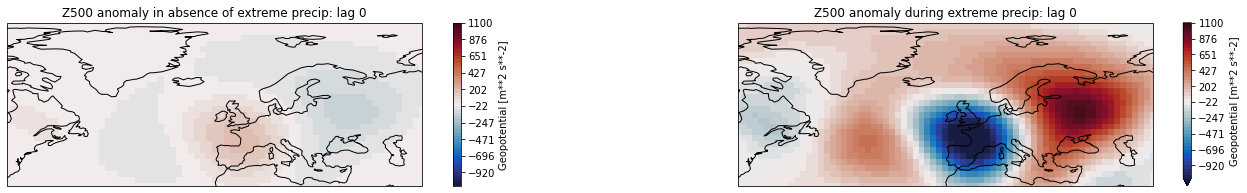

In [15]:
f,a=contourf_grid(composites.Z500.sel(lag=0),(2,1),clevs=np.linspace(-1100,1100),extents=[-80,60,30,85])
a[0].set_title('Z500 anomaly in absence of extreme precip: lag 0')
a[1].set_title('Z500 anomaly during extreme precip: lag 0')

## What about our regime index? We see that this has picked up an extra coordinate 'variable_cat_val' as well as the 'lag' and 'index_val' coordinates. This is because we declared is_categorical=True when we added the regime index to the LaggedAnalyser.

##  Since it doesn't make sense to average a categorical index, the default behaviour of LaggedAnalyser is instead to compute categorical composites in terms of occurrence frequency.
##### See Notebook avanced_precursors for a demonstration of how to change the composite functions

In [16]:
composites.WR7

<xarray.DataArray 'WR7' (lag: 8, index_val: 2, variable_cat_val: 8)>
array([[[-2.65928767e-03, -7.30805011e-03,  1.09422684e-02,
         -2.19367260e-03,  5.30930076e-03,  4.19422971e-03,
         -7.77555153e-03, -5.09237004e-04],
        [ 2.24806449e-02,  6.17795815e-02, -9.25019335e-02,
          1.85445055e-02, -4.48828859e-02, -3.54564832e-02,
          6.57316675e-02,  4.30490330e-03]],

       [[-4.31267702e-03, -8.96434759e-03,  1.06457965e-02,
         -4.01809139e-03,  5.73121529e-03,  5.61386835e-03,
         -5.18425121e-03,  4.88487109e-04],
        [ 3.64577935e-02,  7.57813144e-02, -8.99956679e-02,
          3.39674744e-02, -4.84495970e-02, -4.74575888e-02,
          4.38257627e-02, -4.12949128e-03]],

       [[-7.77625891e-03, -7.73287277e-03,  7.89769296e-03,
         -3.76720630e-03,  4.14054721e-03,  7.68917223e-03,
         -1.67217430e-03,  1.22109988e-03],
        [ 6.57376474e-02,  6.53708768e-02, -6.67642064e-02,
          3.18465836e-02, -3.50026710e-02, -6.50014485e-02,
          1.41359496e-02, -1.03227315e-02]],
...
       [[-5.79212881e-03, -1.30747917e-03,  3.24240687e-03,
         -3.65599001e-03, -9.59289649e-04,  6.54887119e-03,
          3.93524901e-03, -2.01163943e-03],
        [ 4.89645375e-02,  1.10529505e-02, -2.74101213e-02,
          3.09064017e-02,  8.10948368e-03, -5.53617607e-02,
         -3.32671552e-02,  1.70056637e-02]],

       [[-9.13026815e-03, -4.49423860e-04,  3.28799376e-03,
         -1.44101732e-03,  7.11234087e-04,  6.17545168e-03,
          2.37594157e-03, -1.52991176e-03],
        [ 7.71839461e-02,  3.79926486e-03, -2.77954962e-02,
          1.21818332e-02, -6.01251272e-03, -5.22050088e-02,
         -2.00853406e-02,  1.29333142e-02]],

       [[-1.19068242e-02, -4.80784497e-04,  1.11860797e-03,
          2.67822981e-03,  2.22495464e-03,  6.39497614e-03,
          3.94719592e-04, -4.23879482e-04],
        [ 1.00655935e-01,  4.06437621e-03, -9.45630247e-03,
         -2.26407748e-02, -1.88089524e-02, -5.40607882e-02,
         -3.33681500e-03,  3.58332204e-03]]])
Coordinates:
  * variable_cat_val  (variable_cat_val) int64 0 1 2 3 4 5 6 7
  * lag               (lag) int64 0 2 4 6 8 10 12 14
  * index_val         (index_val) int64 0 1
Attributes:
    regime_labels:   ['Neutral', 'AT', 'ZO', 'ScTr', 'AR', 'EuBl', 'ScBl', 'GL']
    is_categorical:  True

Text(0.5, 1.0, 'Regime occurrence anomaly during extreme precip: lag 0')

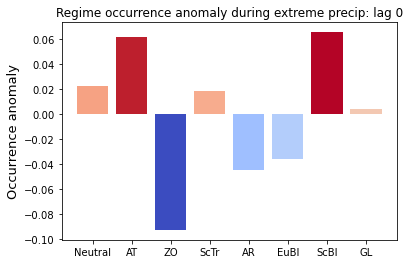

In [17]:
cat_1d_plot(composites.WR7.sel(lag=0,index_val=1))
plt.ylabel('Occurrence anomaly',fontsize=13)
plt.title('Regime occurrence anomaly during extreme precip: lag 0')

### We now filter out anomalies which are statistically insignificant.

### LaggedAnalyser has a bootstrap_significance() method which simply compares the amplitude of composite anomalies to a distribution of randomly generated composites. We can use this to compute significance_masks for our variables:
### 'sig_mask' is a dataset with the same coordinates and variables as 'composites', but which is False where the composite anomaly fails the significance test, and True otherwise
##### N.B. If we wanted to make the bootstrap_significance more efficient, and we knew our variables were stationary, we could set *reuse_lag0_boots=True*. Instead of computing new bootstraps for every time lag we would then just reuse the bootstraps from lag=0.

In [18]:
#This cell may take a few minutes to run. Run time scales linearly with bootnum, and with number of lags if reuse_lag0_boots=False.
sig_mask=analyser.bootstrap_significance(bootnum=100,p=0.05,hb_correction=False)

## We will now use Domino's plotting module to visualise our composites, appropriately masked. We start with the spatial fields:

/home/ws/ox5324/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


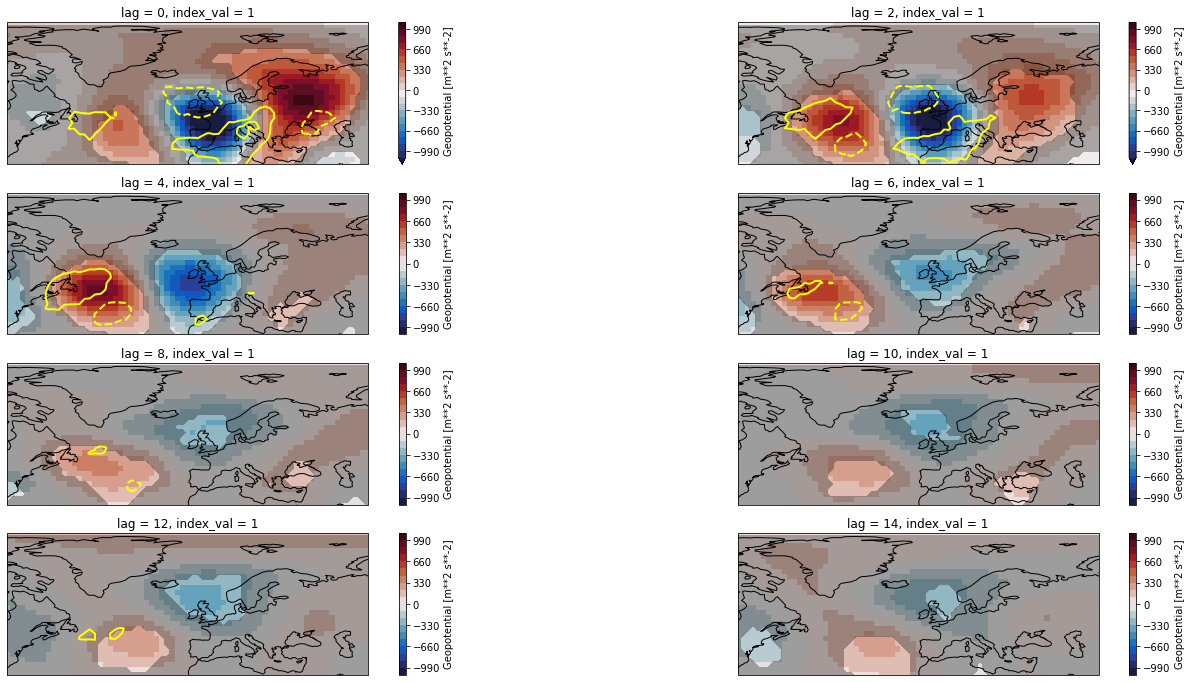

In [19]:
f,a=contourf_grid(composites.Z500[:,1],(2,4),sig_da=sig_mask.Z500[:,1],extents=[-80,60,30,85],clevs=np.linspace(-1100,1100,21))
overlay_contour(composites.IVT[:,1],a,levels=[-75,-25,25,75],colors=['yellow'],linestyles=['--','--','-','-'],linewidths=2,sig_da=sig_mask.IVT[:,1])

### Above the colour fill shows Z500 anomalies, and we have plotted IVT contours in yellow. 
### We have shaded out gridpoints where the Z500 anomaly fails a significance test, and for the overlays, have not plotted any insignificant contours.

### What can we see? Between days 14-8 before an extreme rainfall event the composite shows weak ridging over the West Atlantic. From day 6 onwards we see this anomaly amplify substantially, in combination with strong moisture transport, which drives downstream development of a Rossby wave. When the resulting trough reaches Europe there is large IVT on the South East flank, causing strong rainfall in Northern Italy. Cool!

### What do our regime indices show?

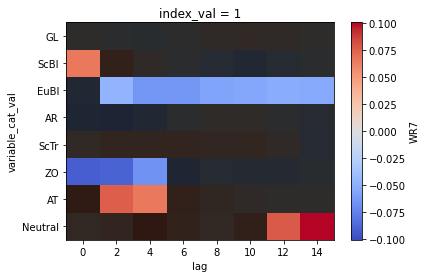

In [20]:
f,a=cat_2d_plot(composites.WR7.sel(index_val=1),sig_da=sig_mask.WR7.sel(index_val=1))

### There are only two particularly clear anomalies in regime occurrence prior to North Italian extreme rainfall. In the five days before the event, zonal flows are far less likely - a natural consequence of the Rossby wave precursor we have just identified. The other signal is that there is a reduced probability of European blocking at all lead times. This is generally consistent with the low geopotential height anomalies seen over Western Europe in the Z500 field.

# Example 2: Identifying the wave breaking signature of regimes:
## We load a field of anticyclonic wavebreaking, and composite it over the 7 regimes
##### N.B: To do this properly you probably would want an event series that contained only the central day of a regime event, whereas in this example we simply composite over all days assigned to a regime.

In [21]:
ARWB=xr.open_dataarray('../example_data/anticyclonic_wavebreaking_djf.nc',chunks=chunks).load()

In [22]:
analyser=LaggedAnalyser(event=regime_index,variables=ARWB)
analyser.dropna('time',event=True,variables=True)
analyser.align()

In [23]:
analyser.lag_variables(np.arange(5,-6,-1))

In [24]:
comp=analyser.compute_composites(as_anomaly=True)

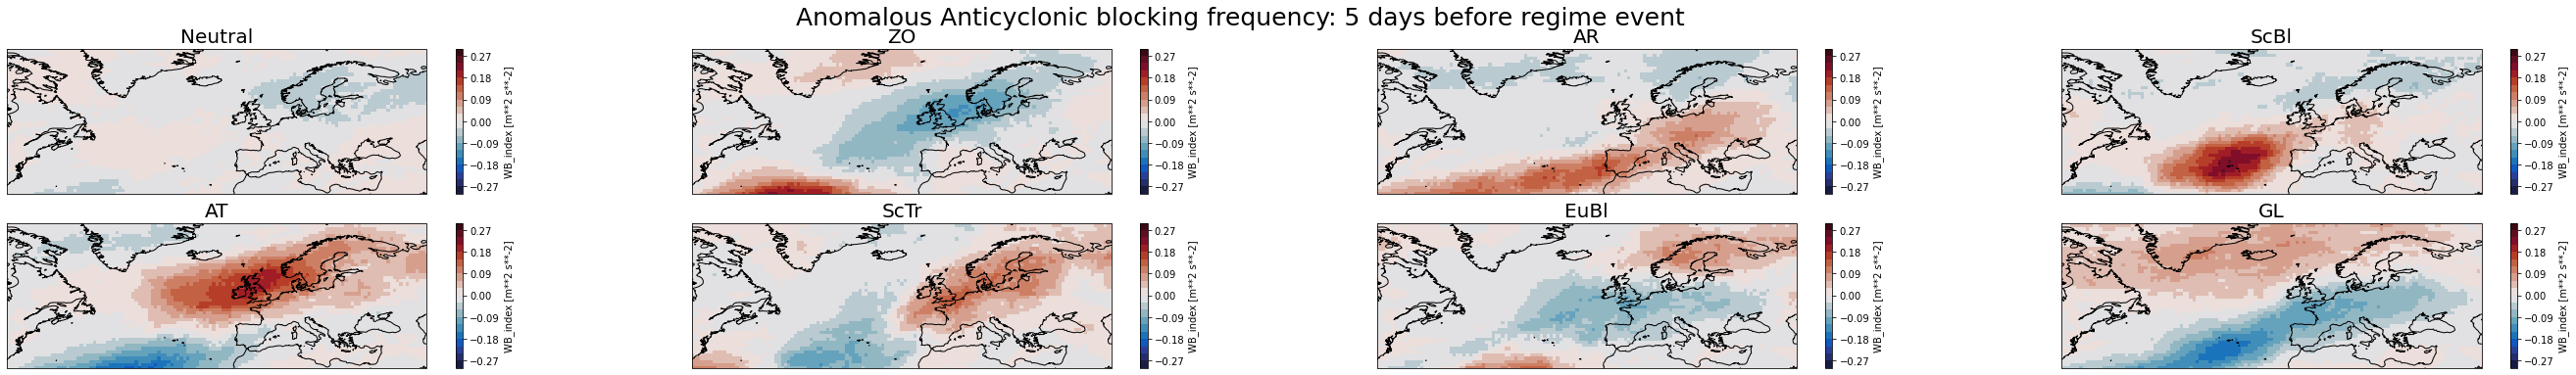

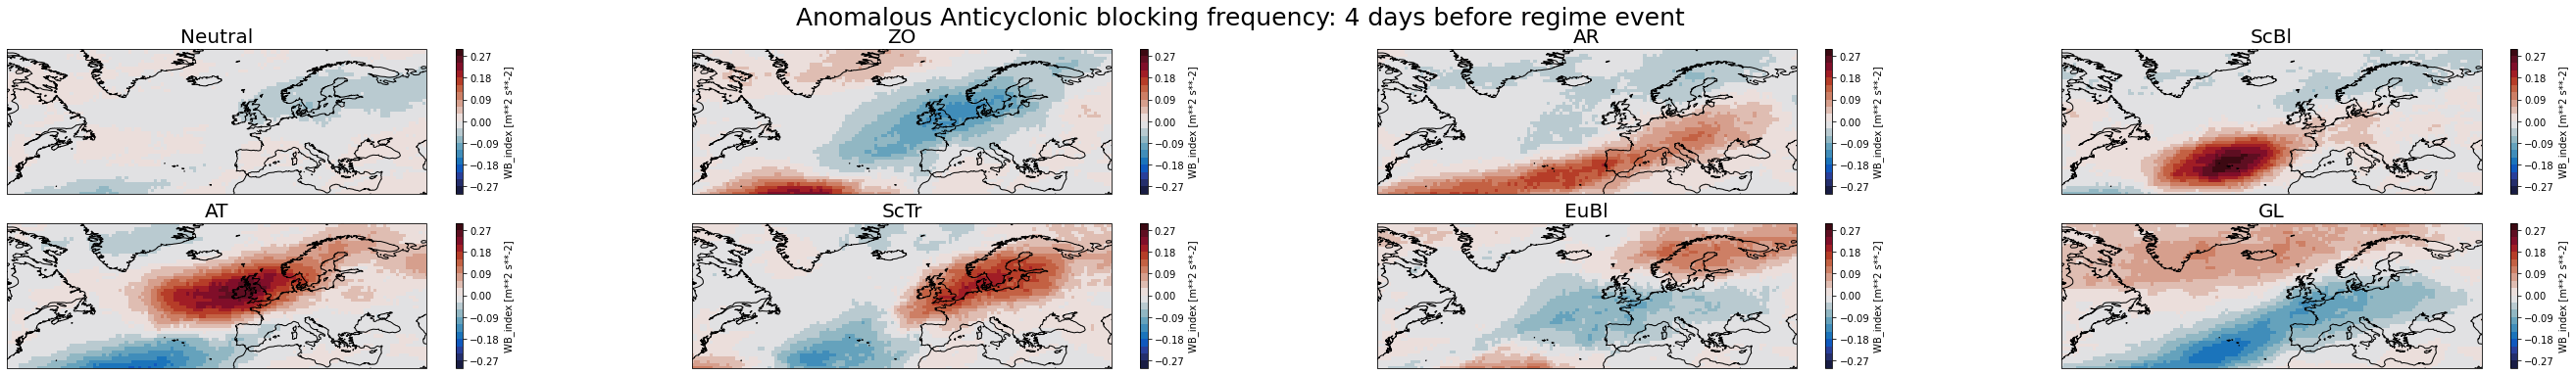

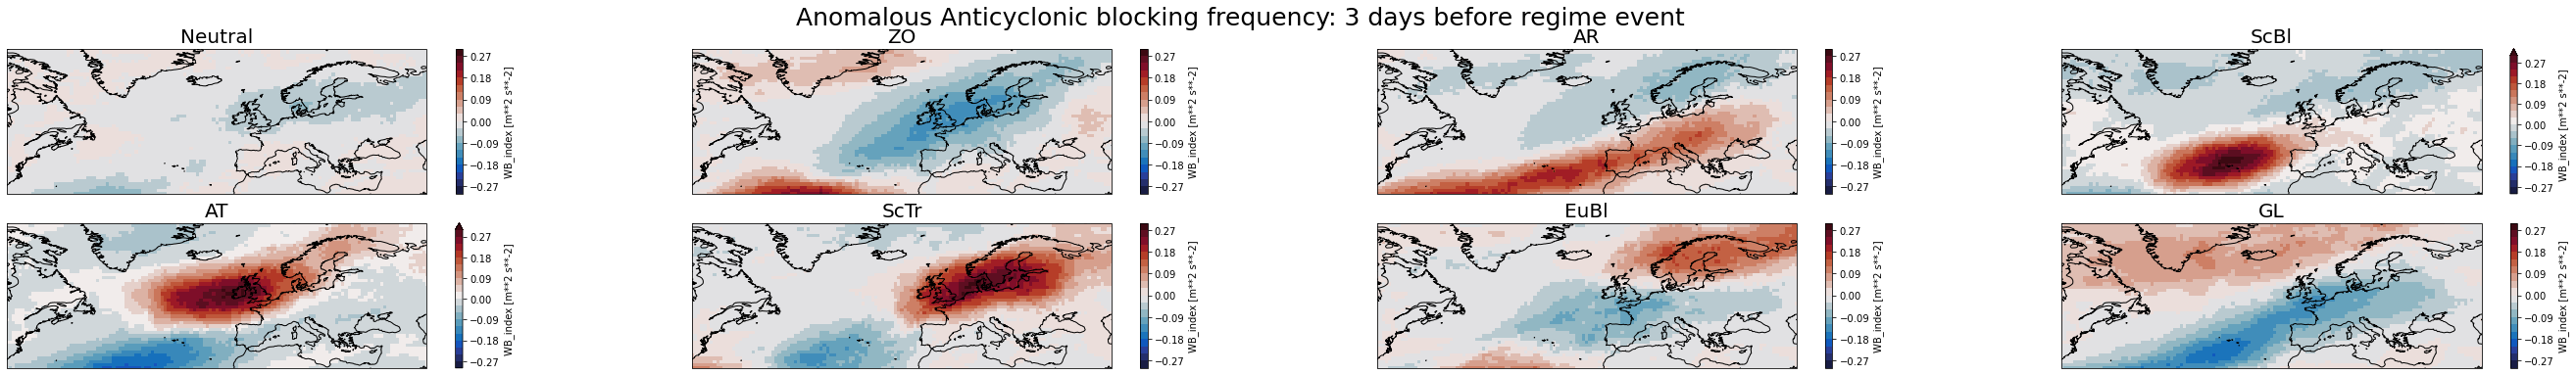

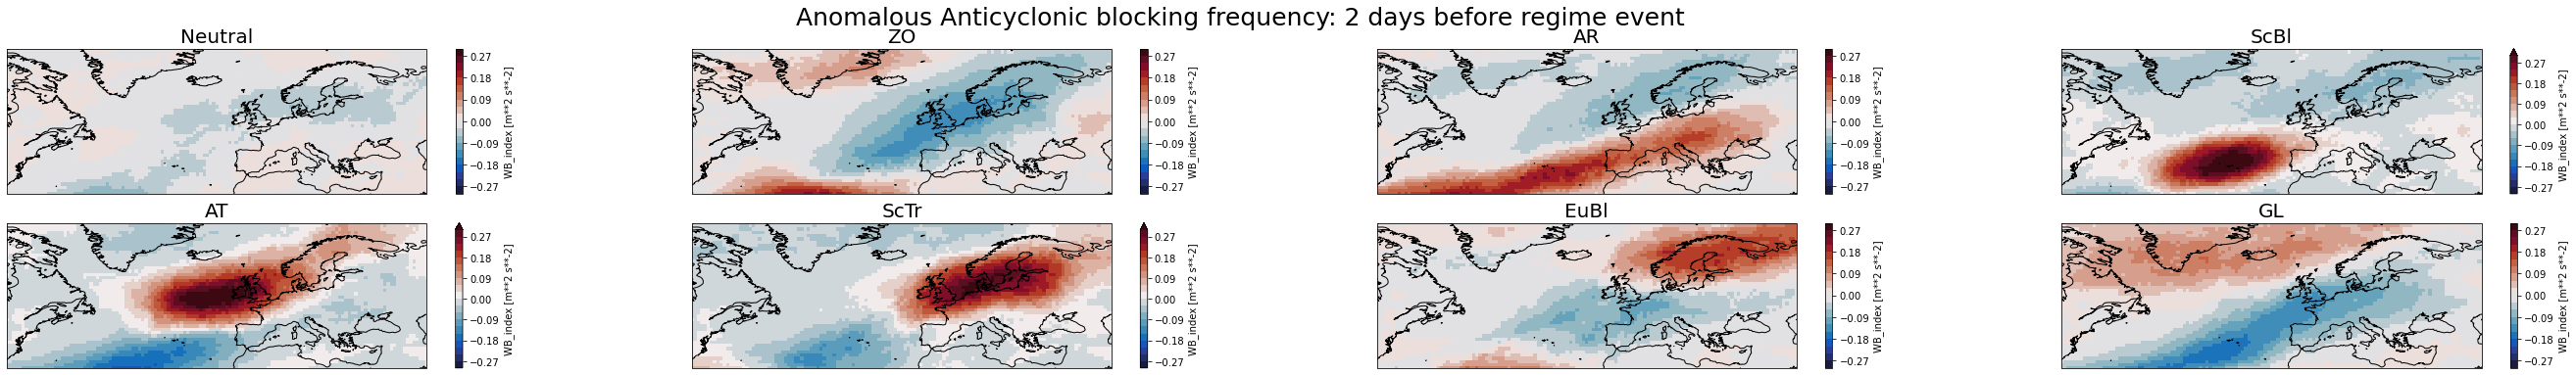

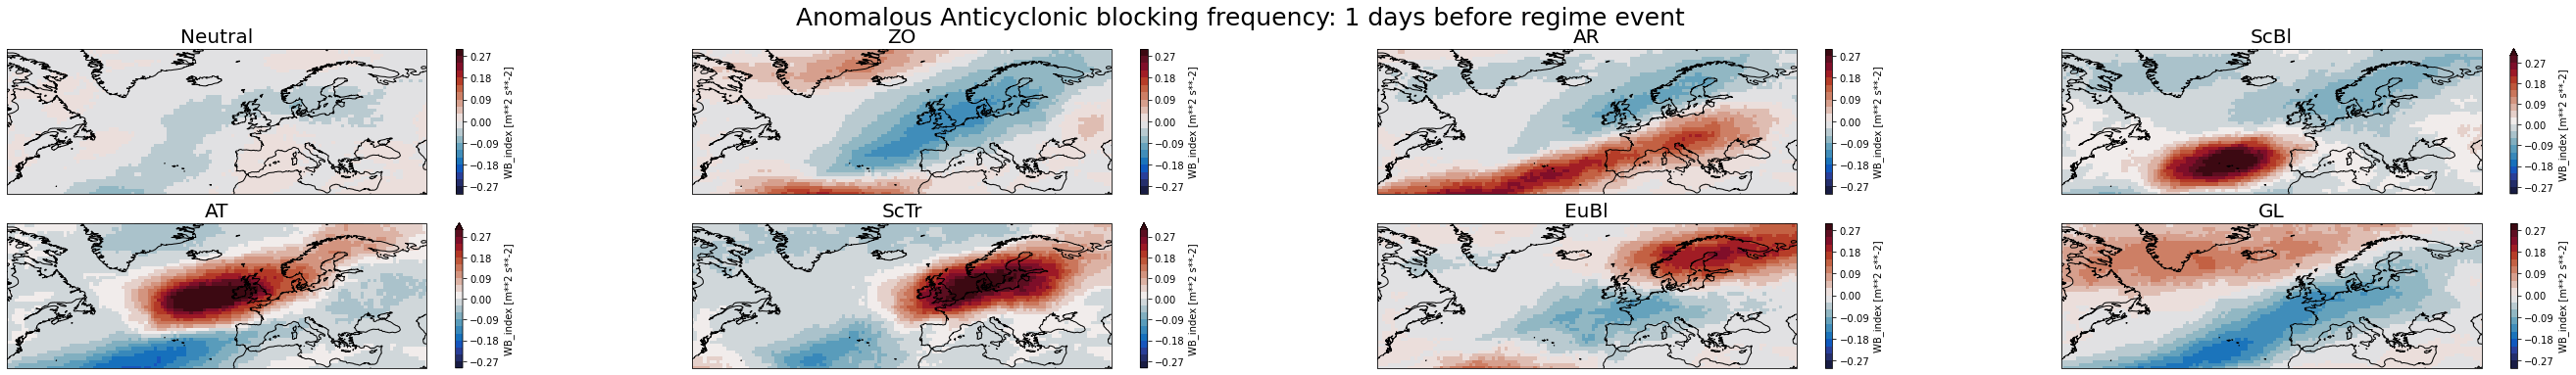

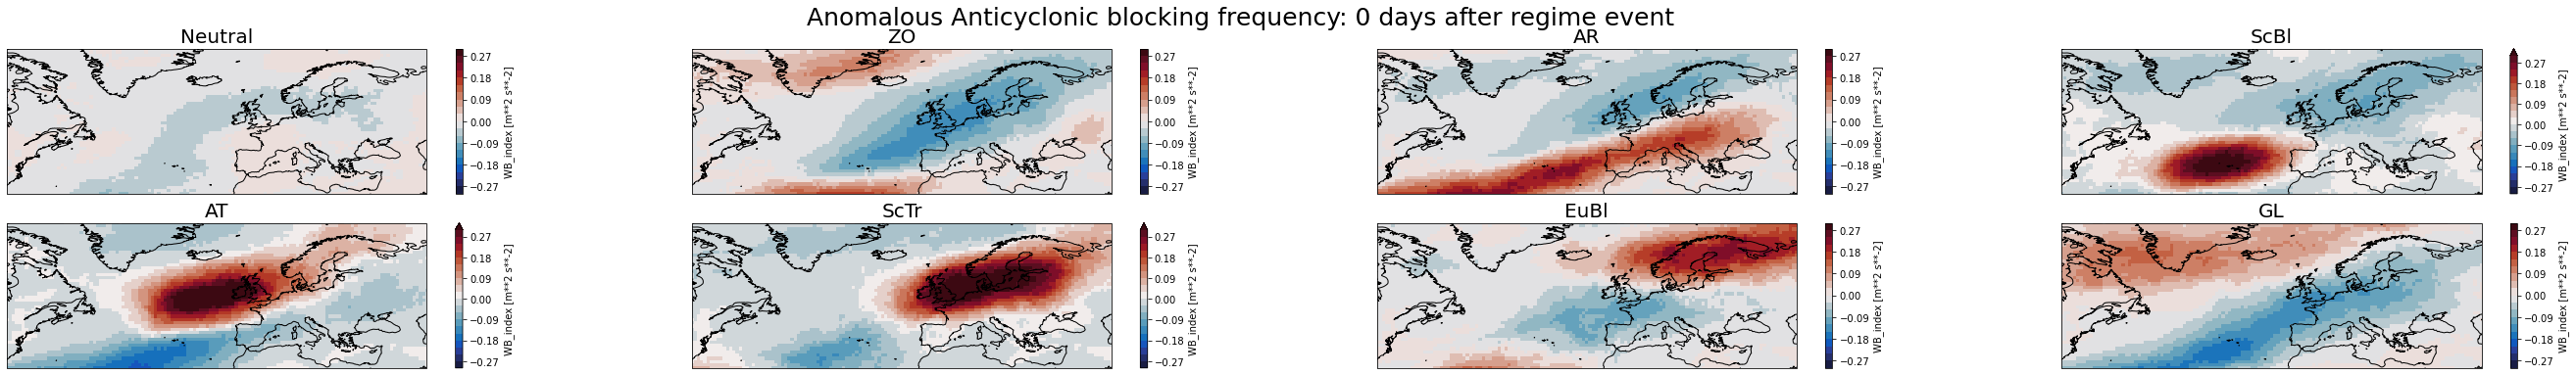

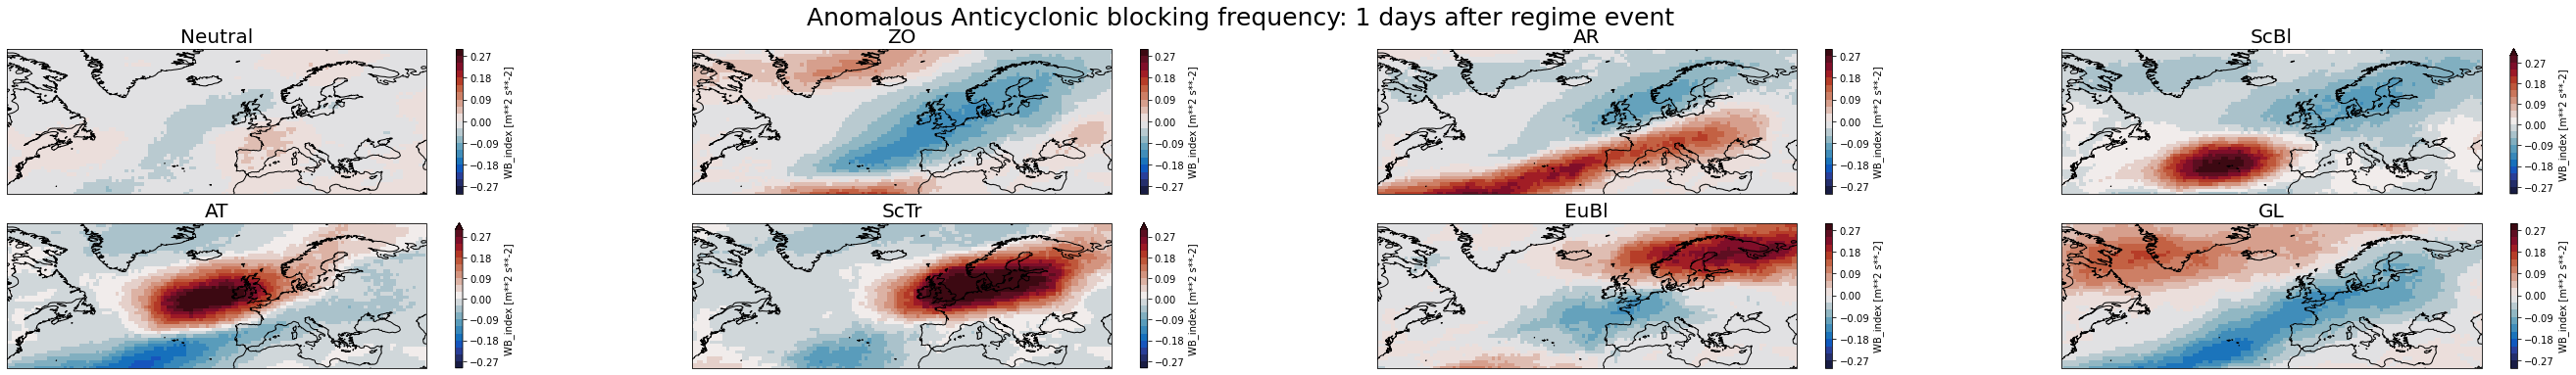

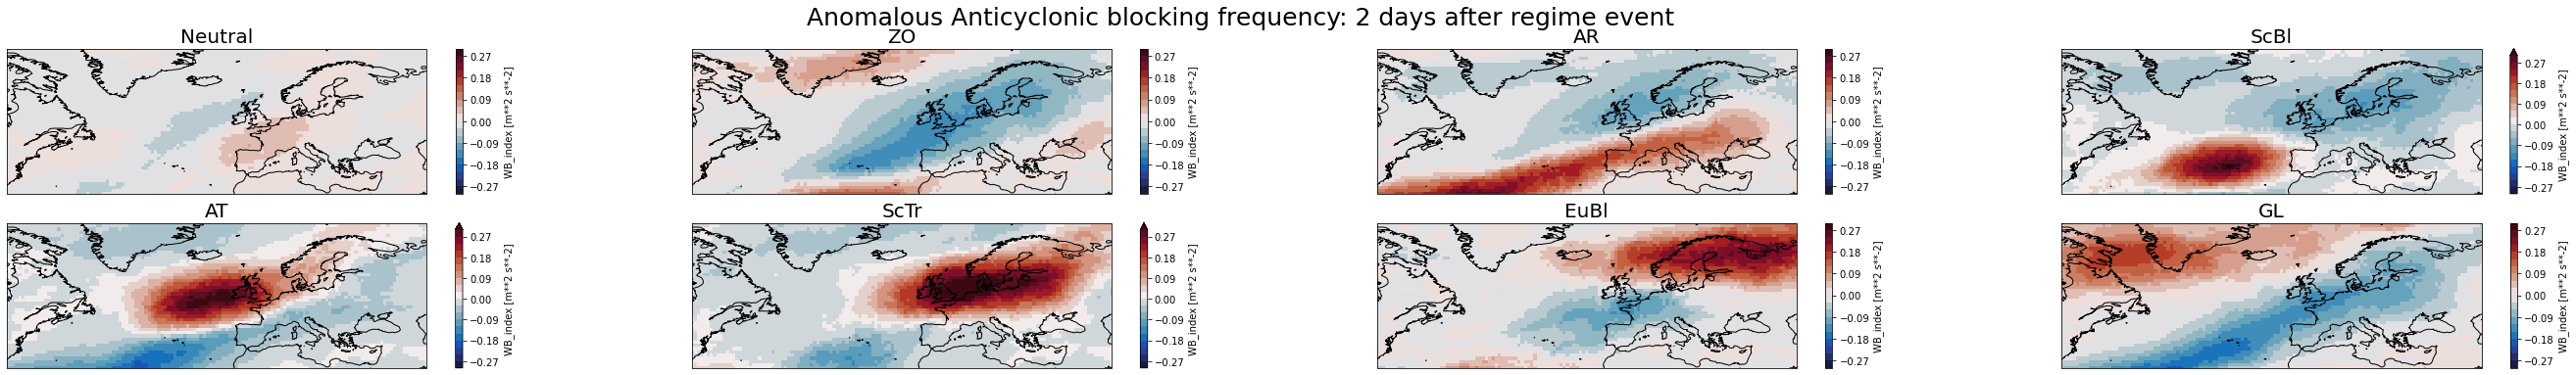

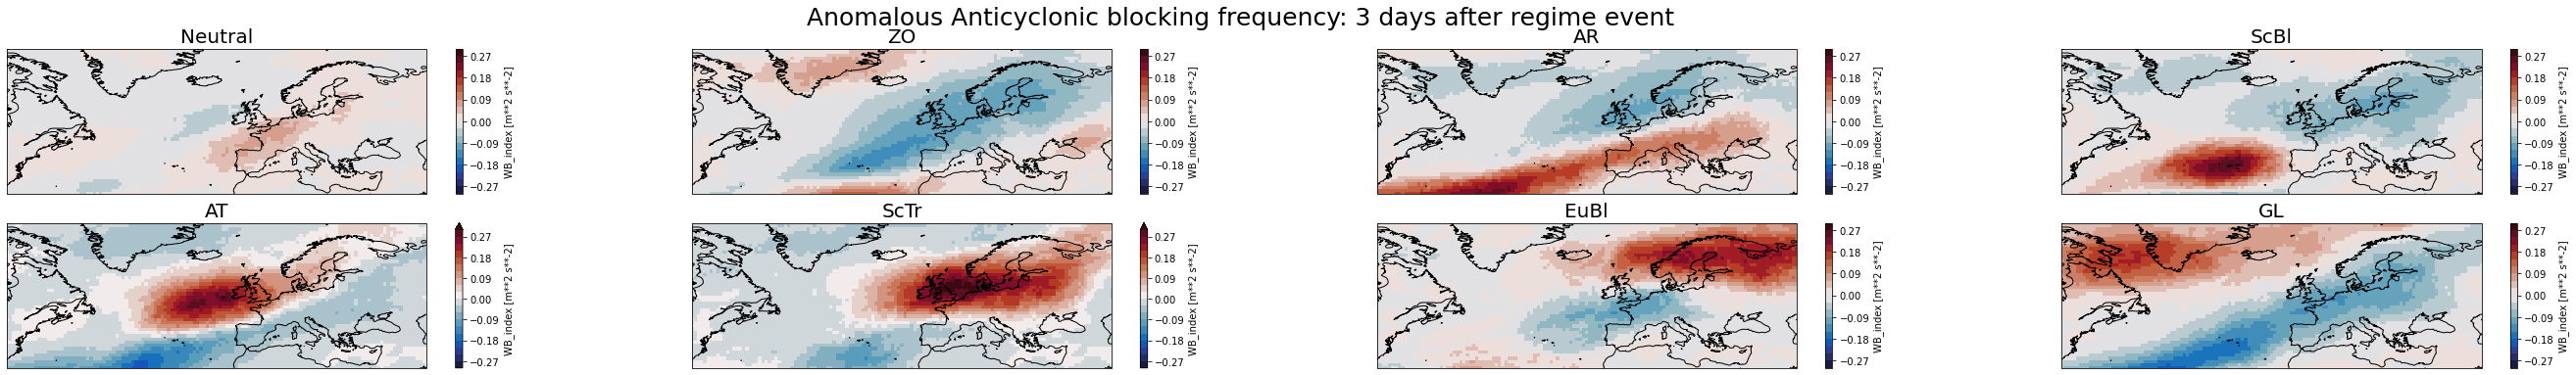

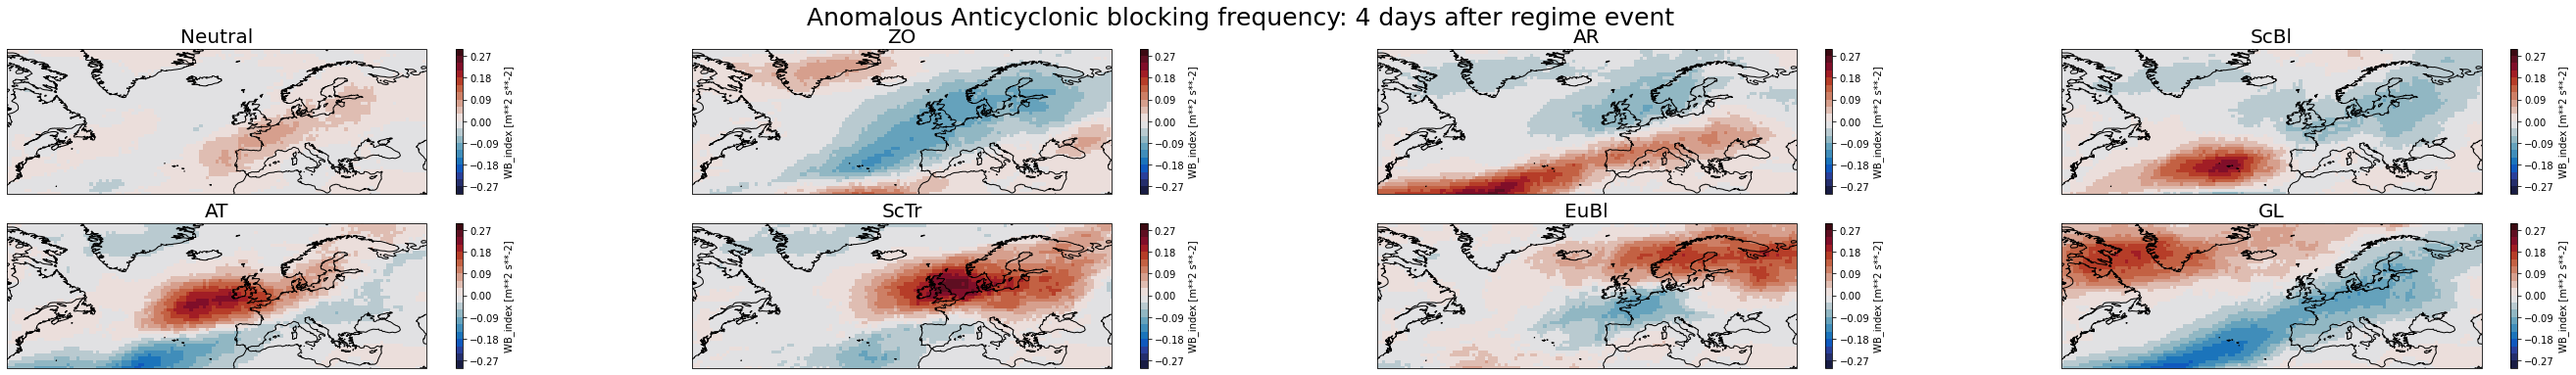

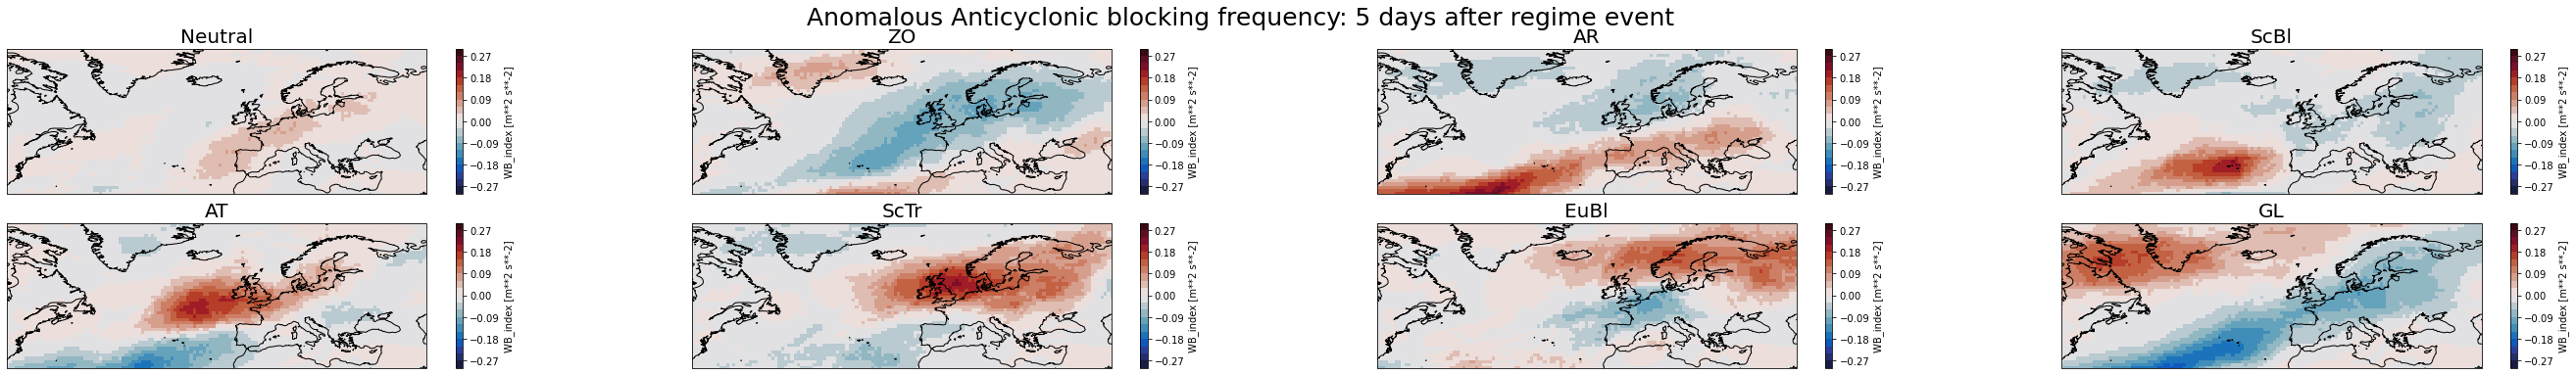

In [25]:
timeword=['before','after']
for l in np.arange(5,-6,-1):
    f,a=contourf_grid(comp.is_anticyclonic.sel(lag=l),(4,2),extents=[-80,50,30,75],clevs=np.linspace(-0.3,0.3,21))
    f.suptitle(f'Anomalous Anticyclonic blocking frequency: {abs(l)} days {timeword[int(l<=0)]} regime event',fontsize=25)
    for i,ax in enumerate(a.reshape(-1)):
        ax.set_title(analyser.event.attrs['regime_labels'][i],fontsize=20)

# Example 3: Case study analysis

### We look at the Z500 and IVT fields before two major Italian flood events

In [26]:
def construct_event_da(start_dt,end_dt,event_dts,**pd_kwargs):
    
    times=pd.date_range(start_dt,end_dt,**pd_kwargs)
    event_series=xr.DataArray(np.zeros(len(times)),coords={'time':times})
    for n,t in enumerate(event_dts):
        event_series=event_series+((event_series.time.values==np.datetime64(t)).astype(int)*(n+1))
    return event_series

flood1994=dt.datetime(1994,11,5)
flood2000=dt.datetime(2000,10,14)
severe_floods=[flood1994,flood2000]
case_studies=construct_event_da(dt.datetime(1990,9,1),dt.datetime(2005,11,30),severe_floods)

#Restrict to SON so that variable composites are anomalies relative to SON
case_studies=case_studies[case_studies['time.season']=='SON']

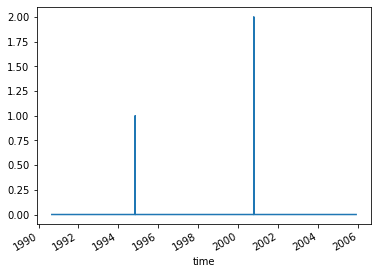

In [27]:
case_studies.plot()

In [28]:
analyser=LaggedAnalyser(event=case_studies,variables={'Z500':Z500_field,'IVT':IVT_field})
analyser.lag_variables(np.arange(-2,3))
analyser.compute_composites()

<xarray.Dataset>
Dimensions:    (lon: 71, lat: 28, lag: 5, index_val: 3)
Coordinates:
  * lon        (lon) float32 -80.0 -78.0 -76.0 -74.0 ... 54.0 56.0 58.0 60.0
  * lat        (lat) float32 30.0 32.0 34.0 36.0 38.0 ... 78.0 80.0 82.0 84.0
  * lag        (lag) int64 -2 -1 0 1 2
  * index_val  (index_val) int64 0 1 2
Data variables:
    Z500       (lag, index_val, lat, lon) float32 dask.array<chunksize=(1, 1, 20, 20), meta=np.ndarray>
    IVT        (lag, index_val, lat, lon) float64 dask.array<chunksize=(1, 1, 20, 20), meta=np.ndarray>

In [31]:
#Compute forces dask to return actual numbers.
#This way we avoid computing the index_val=0 composite which we're not at all interested in.
comp=analyser.composites.sel(index_val=[1,2]).compute()

comp1994=comp.sel(index_val=1)
comp2000=comp.sel(index_val=2)

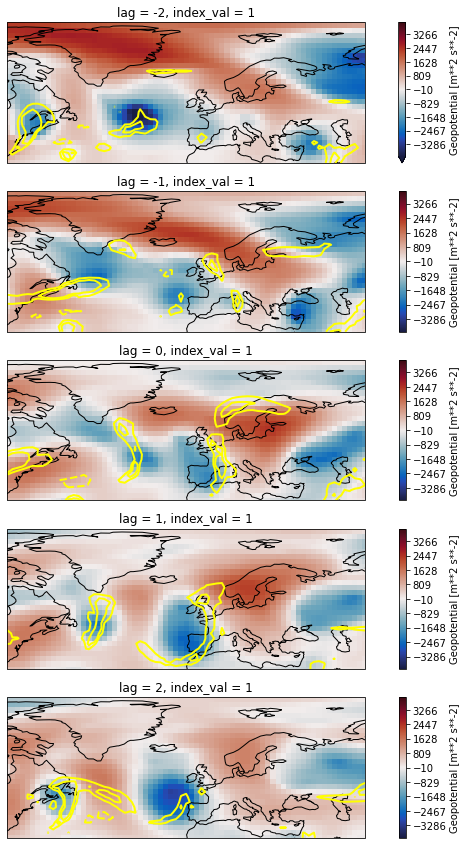

In [43]:
f,a=contourf_grid(comp1994.Z500,(1,5),extents=[-80,60,30,85],clevs=np.arange(-4000,4000,21))
overlay_contour(comp1994.IVT,a,levels=[-300,-150,150,300],colors=['yellow'],linestyles=['--','--','-','-'],linewidths=2)

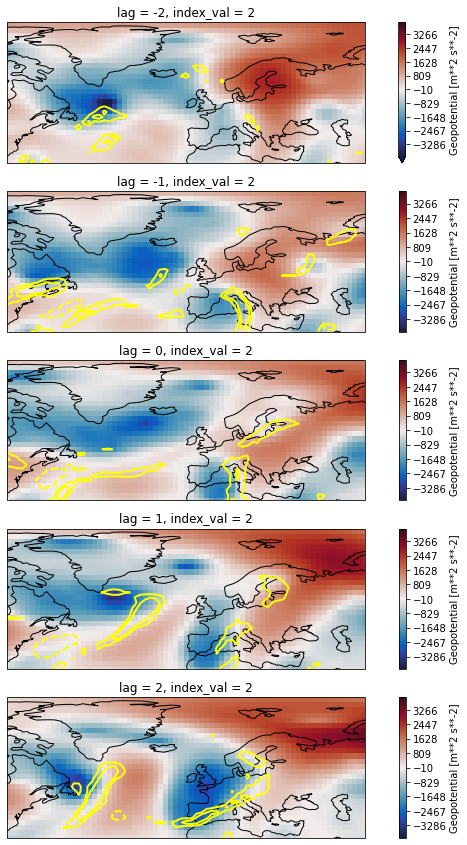

In [44]:
f,a=contourf_grid(comp2000.Z500,(1,5),extents=[-80,60,30,85],clevs=np.arange(-4000,4000,21))
overlay_contour(comp2000.IVT,a,levels=[-300,-150,150,300],colors=['yellow'],linestyles=['--','--','-','-'],linewidths=2)